[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Fine-tune PaliGemma2 on Object Detection Dataset

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/google-research/big_vision/blob/main/big_vision/configs/proj/paligemma/README.md)
[![arXiv](https://img.shields.io/badge/arXiv-2412.03555-b31b1b.svg)](https://arxiv.org/abs/2412.03555)

PaliGemma 2 is built by combining the SigLIP-So400m vision encoder with the more recent and capable language models from the Gemma 2 family.

![PaliGemma2 Figure.1](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/paligemma2-1.png)

The authors use a 3-stage training approach similar to the original PaliGemma. In stage 1, they combine the pretrained vision and language model components and train them jointly on a multimodal task mixture. In stage 2, they train the models at higher resolutions of 448px^2 and 896px^2. In stage 3, they fine-tune the models on the target transfer tasks.

PaliGemma 2 models outperform the original PaliGemma at the same resolution and model size. Increasing the model size and resolution generally improves performance across a wide range of tasks, but the benefits differ depending on the task. Some tasks benefit more from increased resolution, while others benefit more from a larger language model.

![PaliGemma2 Figure.2](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/paligemma2-2.png)

Notebook requires A100 with 40GB of VRAM to train.

## Setup

### Configure your API keys

To fine-tune PaliGemma2, you need to provide your HuggingFace Token and Roboflow API key. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store HuggingFace Access Token under the name `HF_TOKEN`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Select the runtime

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [43]:
!nvidia-smi
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"   #,1"

Wed Oct 22 10:20:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        On  |   00000000:41:00.0 Off |                  N/A |
| 30%   41C    P8             20W /  350W |   19318MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [44]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

### Download dataset from Roboflow Universe

To fine-tune PaliGemma2, prepare your dataset in JSONL format. You can use Roboflow to easily convert any dataset into this format.

In [45]:
#!pip install -q peft bitsandbytes transformers==4.47.0 tf-keras
!rsync -a --progress /data/lmbraid19/argusm/datasets/indoorCVPR_09.tar /tmp/ && mkdir -p /tmp/indoorCVPR && tar -xf /tmp/indoorCVPR_09.tar -C /tmp/indoorCVPR
!rsync -a --progress /work/dlclarge2/zhangj-zhangj-CFM/data/training2 /tmp/
!file /tmp/indoorCVPR
!file /tmp/training2

sending incremental file list
sending incremental file list
/tmp/indoorCVPR: directory
/tmp/training2: directory


**NOTE:** Let's read the first few lines of the annotation file and examine the dataset format.

In [46]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from cvla.data_loader_h5 import H5Dataset
from cvla.data_loader_jsonl import JSONLDataset
from cvla.data_augmentations import augment_image_rgb, RandomizeBackgrounds
from cvla.data_augmentations import complexify_text, DepthAugmentation
from cvla.data_loader_images import ImageFolderDataset
from torchvision import transforms
from torch.utils.data import random_split
import torch
import random

model_location = Path("/data/lmbraid19/argusm/models")
dataset_location = Path("/tmp/training2")

bg_image_dataset = ImageFolderDataset("/tmp/indoorCVPR/Images", transform=transforms.RandomResizedCrop((448,448)))
randomize_background = RandomizeBackgrounds(p=0.2, background_images=bg_image_dataset)
augment_depth = DepthAugmentation(depth_range=(25, 100), max_delta_depth=35)

full_dataset = H5Dataset(
    dataset_location,
    augment_rgb=augment_image_rgb,
    augment_text=complexify_text,
    augment_depth=augment_depth,
    return_depth=True,
    action_encoder="xyzrotvec-cam-512xy",
)

# 手动定义验证集大小
val_size = 1000  # 固定1000条
train_size = len(full_dataset) - val_size

generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=generator)

val_indices_small = random.sample(range(len(val_dataset)), 200)
val_dataset_small = torch.utils.data.Subset(val_dataset, val_indices_small)

print(f"Total samples: {len(full_dataset)} | Train: {len(train_dataset)} | Val: {len(val_dataset)}| Smallv:{len(val_dataset_small)}")


'''
train_dataset = H5Dataset(dataset_location, augment_rgb=augment_image_rgb, augment_text=complexify_text,
                          augment_depth=augment_depth, return_depth=True,action_encoder="xyzrotvec-cam-512xy")
#, augment_rgbds=randomize_background

print("dataset_location:", dataset_location,"samples:", len(train_dataset))
'''

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Total samples: 88244 | Train: 87244 | Val: 1000| Smallv:200


'\ntrain_dataset = H5Dataset(dataset_location, augment_rgb=augment_image_rgb, augment_text=complexify_text,\n                          augment_depth=augment_depth, return_depth=True,action_encoder="xyzrotvec-cam-512xy")\n#, augment_rgbds=randomize_background\n\nprint("dataset_location:", dataset_location,"samples:", len(train_dataset))\n'

### Set up and test data loaders


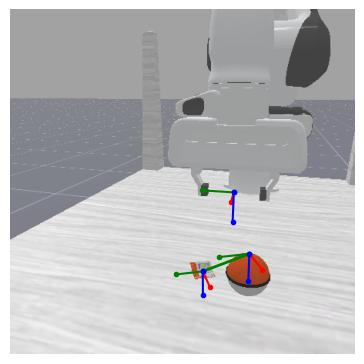
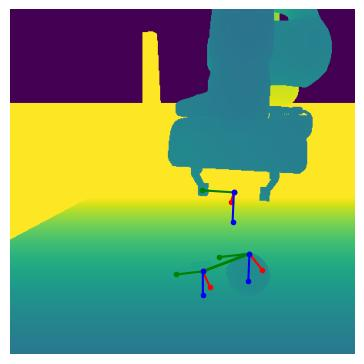
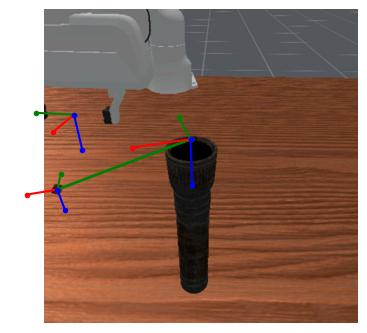
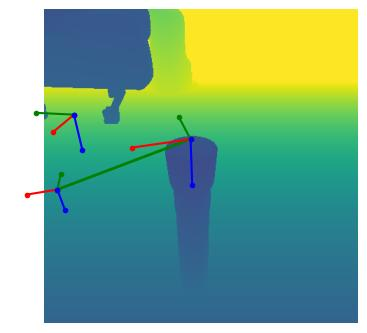
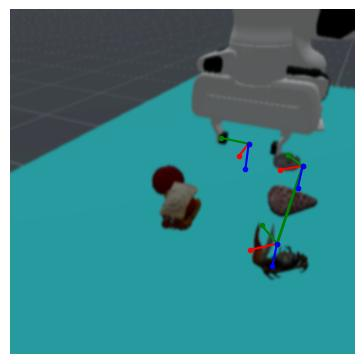
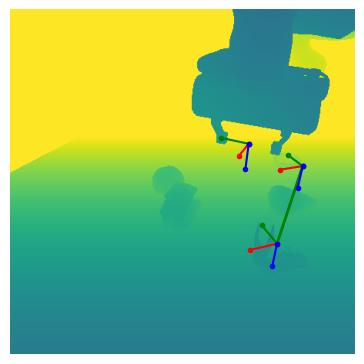
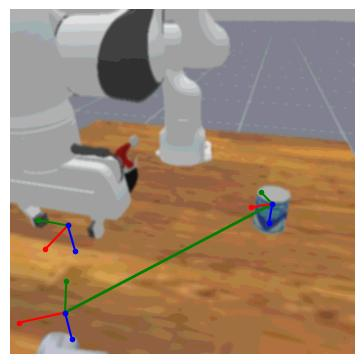
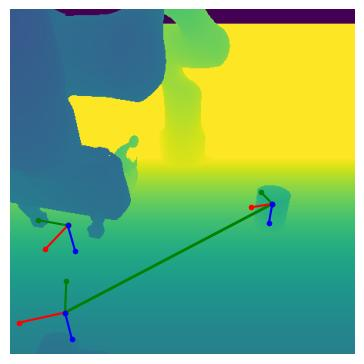
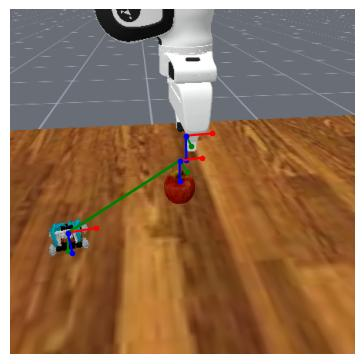
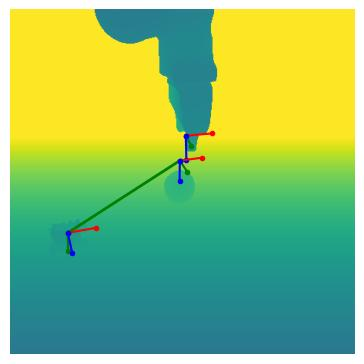
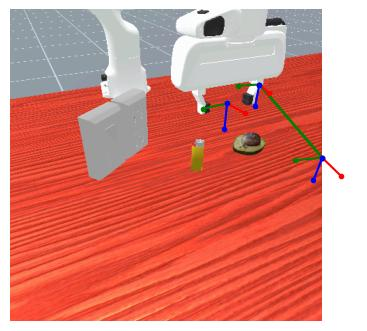
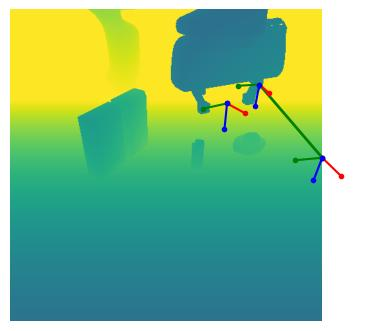

In [47]:
from cvla.utils_vis import render_example
import matplotlib.pyplot as plt
from cvla.utils_traj_tokens import getActionEncInstance

enc = getActionEncInstance("xyzrotvec-cam-512xy")
num_samples = 3*2
html_imgs = ""
for i in range(num_samples):
    image, sample = train_dataset[i]
    prefix = sample["prefix"]
    html_imgs += render_example(image[0], label=sample["suffix"], enc=enc, text=prefix, camera=sample["camera"])
    html_imgs += render_example(image[1], label=sample["suffix"], enc=enc, text=prefix, camera=sample["camera"])

plot_images = True
if plot_images:
    from IPython.display import display, HTML
    display(HTML(html_imgs))
    

### Load PaliGemma2 model

**NOTE:** PaliGemma2 offers 9 pre-trained models with sizes of `3B`, `10B`, and `28B` parameters, and resolutions of `224`, `448`, and `896` pixels. In this tutorial, I'll be using the [`google/paligemma2-3b-pt-448`](https://huggingface.co/google/paligemma2-3b-pt-448) checkpoint. Resolution has a key impact on the mAP of the trained model, and it seems that `448` offers the most optimal balance between performance and compute resources required to train the model.

In [48]:
# from huggingface_hub import notebook_login
# notebook_login()

In [57]:
from transformers import PaliGemmaProcessor, PaliGemmaForConditionalGeneration
import torch

# setting device on GPU if available, else CPU
print("cuda visible devices:", os.environ["CUDA_VISIBLE_DEVICES"])
devices_good = sorted((int(x) for x in os.environ["CUDA_VISIBLE_DEVICES"].split(",")))
DEVICE = torch.device('cuda')
print(DEVICE)
print('Using device:', DEVICE)
print("Good devices", devices_good)

TORCH_DTYPE = torch.bfloat16
# use checkpoint
#LOCAL_CHECKPOINT = "/data/lmbraid19/argusm/models/_text_lr3e-05xyzrotvec-cam-512xy256d_2025-04-23_12-03-48/checkpoint-4687"

#fine-tune directly on paligemma2
MODEL_NAME = "google/paligemma2-3b-pt-224"

processor = PaliGemmaProcessor.from_pretrained("google/paligemma2-3b-pt-224")
model = PaliGemmaForConditionalGeneration.from_pretrained(
    #LOCAL_CHECKPOINT,
    MODEL_NAME,
    torch_dtype=TORCH_DTYPE,
    device_map=None,
    attn_implementation='eager'
)
#.to("cuda") 
tokenizer = processor.tokenizer


cuda visible devices: 0,1
cuda
Using device: cuda
Good devices [0, 1]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [50]:
import random
def augment_suffix(suffix):
    parts = suffix.split(' ; ')
    random.shuffle(parts)
    return ' ; '.join(parts)

def collate_fn(batch):
    images, labels = zip(*batch)
    prefixes = ["<image>" + label["prefix"] for label in labels]
    suffixes = [augment_suffix(label["suffix"]) for label in labels]

    inputs = processor(
        text=prefixes,
        images=images,
        return_tensors="pt",
        suffix=suffixes,
        padding="longest"
    ).to(TORCH_DTYPE).to(DEVICE)

    return inputs

In [51]:
def collate_fn(batch):
    images, labels = zip(*batch)
    prefixes = [label["prefix"] for label in labels]
    suffixes = [augment_suffix(label["suffix"]) for label in labels]
    inputs = processor(
        text=prefixes,
        images=list(images),
        return_tensors="pt",
        suffix=suffixes,
        padding="longest"
    ).to(TORCH_DTYPE)#.to(DEVICE)
    print("prefixes", prefixes)
    return inputs

batch = [train_dataset[i] for i in range(3)]
inputs = collate_fn(batch)
for x in inputs:
    print(x, inputs[x].shape)

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


prefixes ['put the red folder in the red ball <loc0271><loc0331><loc0049><seg045><seg087><seg094>', 'put the pyramid shaped keycap in the cylindrical dark flashlight <loc0171><loc0049><loc0036><seg048><seg080><seg094>', 'put the fiddler crab in the conical seashell <loc0199><loc0353><loc0054><seg051><seg084><seg101>']
input_ids torch.Size([3, 545])
token_type_ids torch.Size([3, 545])
attention_mask torch.Size([3, 545])
pixel_values torch.Size([6, 3, 224, 224])
labels torch.Size([3, 545])


In [52]:
inputs["input_ids"]

tensor([[     0,      0,      0,  ..., 257106, 257111,      1],
        [257152, 257152, 257152,  ..., 257115, 257139,      1],
        [     0, 257152, 257152,  ..., 257116, 257138,      1]])

In [53]:
def collate_fn(batch):
    images, labels = zip(*batch)
    prefixes = ["<image><image>" + label["prefix"] for label in labels]
    suffixes = [augment_suffix(label["suffix"]) for label in labels]
    images_flat = [img for img_list_x in images for img in img_list_x]
    inputs = processor(
        text=prefixes,
        images=images_flat,
        return_tensors="pt",
        suffix=suffixes,
        padding="longest"
    ).to(TORCH_DTYPE)
    return inputs

batch = [train_dataset[i] for i in range(3)]
inputs = collate_fn(batch)
for x in inputs:
    print(x, inputs[x].shape)

input_ids torch.Size([3, 548])
token_type_ids torch.Size([3, 548])
attention_mask torch.Size([3, 548])
pixel_values torch.Size([6, 3, 224, 224])
labels torch.Size([3, 548])


In [54]:
inputs["input_ids"]

tensor([[     0,      0,      0,  ..., 257106, 257111,      1],
        [     0,      0,      0,  ..., 257115, 257139,      1],
        [257152, 257152, 257152,  ..., 257116, 257138,      1]])

In [90]:
from cvla.utils_eval import Evaluator
from transformers import Seq2SeqTrainingArguments
from transformers import Seq2SeqTrainer
import torch
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from math import ceil



TRAIN_EXAMPLES = len(train_dataset)
BATCH_SIZE = 32
BATCH_SIZE_DEV = 2
GRAD_ACCUM = int(round(BATCH_SIZE / BATCH_SIZE_DEV))
TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
SEQLEN = 12
#EVAL_STEPS = 200
EVAL_STEPS = 200
SAVE_LIMIT = 5
LOGGING_STEPS = 10


run_name = "_topview_70000_baseline_depth"
new_model_location = Path("/work/dlclarge2/zhangj-zhangj-CFM/models")
save_path = new_model_location / (str(Path(dataset_location).stem) + run_name)
print("save_path", save_path)
print("TRAIN_STEPS",TRAIN_STEPS)
print("GRAD_ACCUM", GRAD_ACCUM)

writer = SummaryWriter(log_dir=str(save_path / "tb_logs"))

class CustomTrainer(Seq2SeqTrainer):
    """
    Trainer that:
      - uses normal loss for training
      - runs model.generate() for evaluation
      - uses Evaluator to compute real-world metrics
    """

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
    
        outputs = model(**inputs)
        loss = getattr(outputs, "loss", None)
        if loss is None:
            raise ValueError("Model outputs do not contain a 'loss' field.")

        if self.state.global_step % self.args.logging_steps == 0:
            writer.add_scalar("train/loss_total", loss.item(), self.state.global_step)
            writer.add_scalar("train/lr", self.optimizer.param_groups[0]["lr"], self.state.global_step)

        return (loss, outputs) if return_outputs else loss

    def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
        """
        Overridden evaluation that generates predictions textually
        and computes spatial metrics via Evaluator.
        """
        self.model.eval()
        dataset = eval_dataset or self.eval_dataset
        # helper: unwrap nested Subsets to access H5Dataset
        def unwrap_dataset(dset):
            while hasattr(dset, "dataset"):
                dset = dset.dataset
            return dset

        base_dataset = unwrap_dataset(dataset)
        camera = dataset[0][1]["camera"]

        evaluator = Evaluator(
            getActionEncInstance("xyzrotvec-cam-512xy"),
            camera_fixed=camera,
            encoder_labels=base_dataset.action_encoder,  # ✅ now always valid
        )
        # sample limited subset for speed
        eval_batch_size = self.args.per_device_eval_batch_size
        test_samples = min(len(dataset), 200)
        device = next(self.model.parameters()).device
        
        for start_idx in tqdm(range(0, test_samples, eval_batch_size), total=ceil(test_samples / eval_batch_size)):
            batch_i = range(start_idx, min(start_idx + eval_batch_size, test_samples))
            batch = [dataset[i] for i in batch_i]
            inputs = self.data_collator(batch)
            inputs = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in inputs.items()}
            prefix_length = inputs["input_ids"].shape[-1]

            with torch.inference_mode():
                generation = self.model.generate(**inputs, max_new_tokens=13, do_sample=False, use_cache=False)
                decoded = [
                    self.processing_class.decode(x[prefix_length:], skip_special_tokens=True) for x in generation
                ]
                decoded_labels = [
                    self.processing_class.decode([t for t in x.tolist() if t >= 0], skip_special_tokens=True)
                    for x in inputs["labels"]
                ]


            for pred, label in zip(decoded, decoded_labels):
                evaluator.evaluate(pred, label, camera=camera)

        stats = evaluator.report_stats()
        metrics = {f"{metric_key_prefix}/{k}": v for k, v in stats.items()}

        # log to TensorBoard
        for k, v in metrics.items():
            writer.add_scalar(k, v, self.state.global_step)

        self.log(metrics)
        return metrics
'''
import numpy as np
def compute_metrics(eval_pred):
    predictions, label_tokens = eval_pred  # Extract predictions and labels
    if isinstance(predictions, tuple):  # Some models return tuples
        predictions = predictions[0]

    # Convert to token indices if necessary (e.g., for text generation models)
    pred_tokens = np.argmax(predictions, axis=-1)  # Assuming logits, take argmax

    pred_texts = processor.tokenizer.batch_decode(pred_tokens[:,-SEQLEN-1:], skip_special_tokens=True)
    label_text = processor.tokenizer.batch_decode(label_tokens[:,-SEQLEN-1:], skip_special_tokens=True)

    print(pred_tokens[:,-SEQLEN-1:])
    print(label_tokens[:,-SEQLEN-1:])
    print(label_text)
    print(pred_texts)
    print()
    return {"accuracy": 0}
'''

save_path /work/dlclarge2/zhangj-zhangj-CFM/models/training2_topview_70000_baseline_depth
TRAIN_STEPS 2726
GRAD_ACCUM 16


'\nimport numpy as np\ndef compute_metrics(eval_pred):\n    predictions, label_tokens = eval_pred  # Extract predictions and labels\n    if isinstance(predictions, tuple):  # Some models return tuples\n        predictions = predictions[0]\n\n    # Convert to token indices if necessary (e.g., for text generation models)\n    pred_tokens = np.argmax(predictions, axis=-1)  # Assuming logits, take argmax\n\n    pred_texts = processor.tokenizer.batch_decode(pred_tokens[:,-SEQLEN-1:], skip_special_tokens=True)\n    label_text = processor.tokenizer.batch_decode(label_tokens[:,-SEQLEN-1:], skip_special_tokens=True)\n\n    print(pred_tokens[:,-SEQLEN-1:])\n    print(label_tokens[:,-SEQLEN-1:])\n    print(label_text)\n    print(pred_texts)\n    print()\n    return {"accuracy": 0}\n'

## Fine-tune with JAX settings

In [88]:

for param in model.vision_tower.parameters():
    param.requires_grad = False

for param in model.multi_modal_projector.parameters():
    param.requires_grad = False
    
for name, param in model.named_parameters():
    if param.requires_grad == True:
        if "self_attn" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

args_jax = Seq2SeqTrainingArguments(
    max_steps=TRAIN_STEPS,
    per_device_train_batch_size=BATCH_SIZE_DEV,
    gradient_accumulation_steps=GRAD_ACCUM,
    learning_rate=3e-5,
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,
    generation_max_length=SEQLEN,
    logging_steps=LOGGING_STEPS,
    optim="adafactor",
    evaluation_strategy="steps",
    eval_steps=EVAL_STEPS,
    save_strategy="steps",
    save_steps=EVAL_STEPS,
    save_total_limit=SAVE_LIMIT,
    load_best_model_at_end=True,
    metric_for_best_model="eval/cart_l1",
    greater_is_better=False,
    bf16=True,
    output_dir=save_path,
    report_to=["tensorboard"],
    dataloader_num_workers=4,
    remove_unused_columns=False,
)

trainer = CustomTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset_small,
    data_collator=collate_fn,  # replace with your collate_fn if you use one
    args=args_jax,
)

/home/zhangj/miniconda3/envs/mani_skill_clean/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_297609/851296537.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


In [ ]:
#only when recover from last time training
#last_checkpoint = "/work/dlclarge2/zhangj-zhangj-CFM/models/training2_topview_70000_based/checkpoint-183"
#trainer.train(resume_from_checkpoint=last_checkpoint)


In [89]:
trainer.train()
trainer.save_model(str(save_path / "final_checkpoint"))
writer.close()
print("✅ Training completed successfully with Evaluator-based validation.")

Step,Training Loss,Validation Loss


 20%|█████████████████▏                                                                    | 5/25 [00:39<02:39,  7.98s/it]


KeyboardInterrupt: 

In [11]:
for key, value in inputs.items():
    if torch.is_tensor(value):
        inputs[key] = value.to(DEVICE)

In [ ]:
print("Model device:", next(model.parameters()).device)
for k, v in inputs.items():
    if torch.is_tensor(v):
        print(f"  {k}: {v.device}")


In [ ]:
print(next(model.parameters()).device)
print({k: v.device for k, v in inputs.items() if torch.is_tensor(v)})